- Single shot detectors try posing object detection as a regression problem. One of the main architectures under this category is the YOLO architecture (You Only Look Once) which we will explore in more detail now.
- The main idea of the YOLO network is to optimise the computation of  predictions at various locations in the input image without using any sliding windows.In order to achieve this, the network outputs feature map in form of a  grid of size N*N cells.

- Each cell has B*5+C entries. Where "B" is the number of bounding boxes per cell, C is the number of class probabilities and 5 is the elements for each bounding box (x, y :center point coordinates of bounding box with respect to the cell in which it is located , w-width of the bounding box with respect to original image, h-height of the bounding box with respect to original image, confidence score: how likely object is present in the bounding box). 

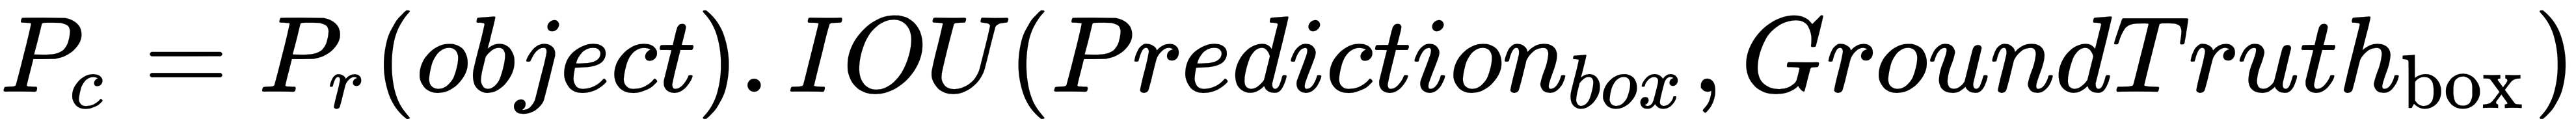

In [4]:
from IPython.display import Image
Image(filename='./images/yolo.png')

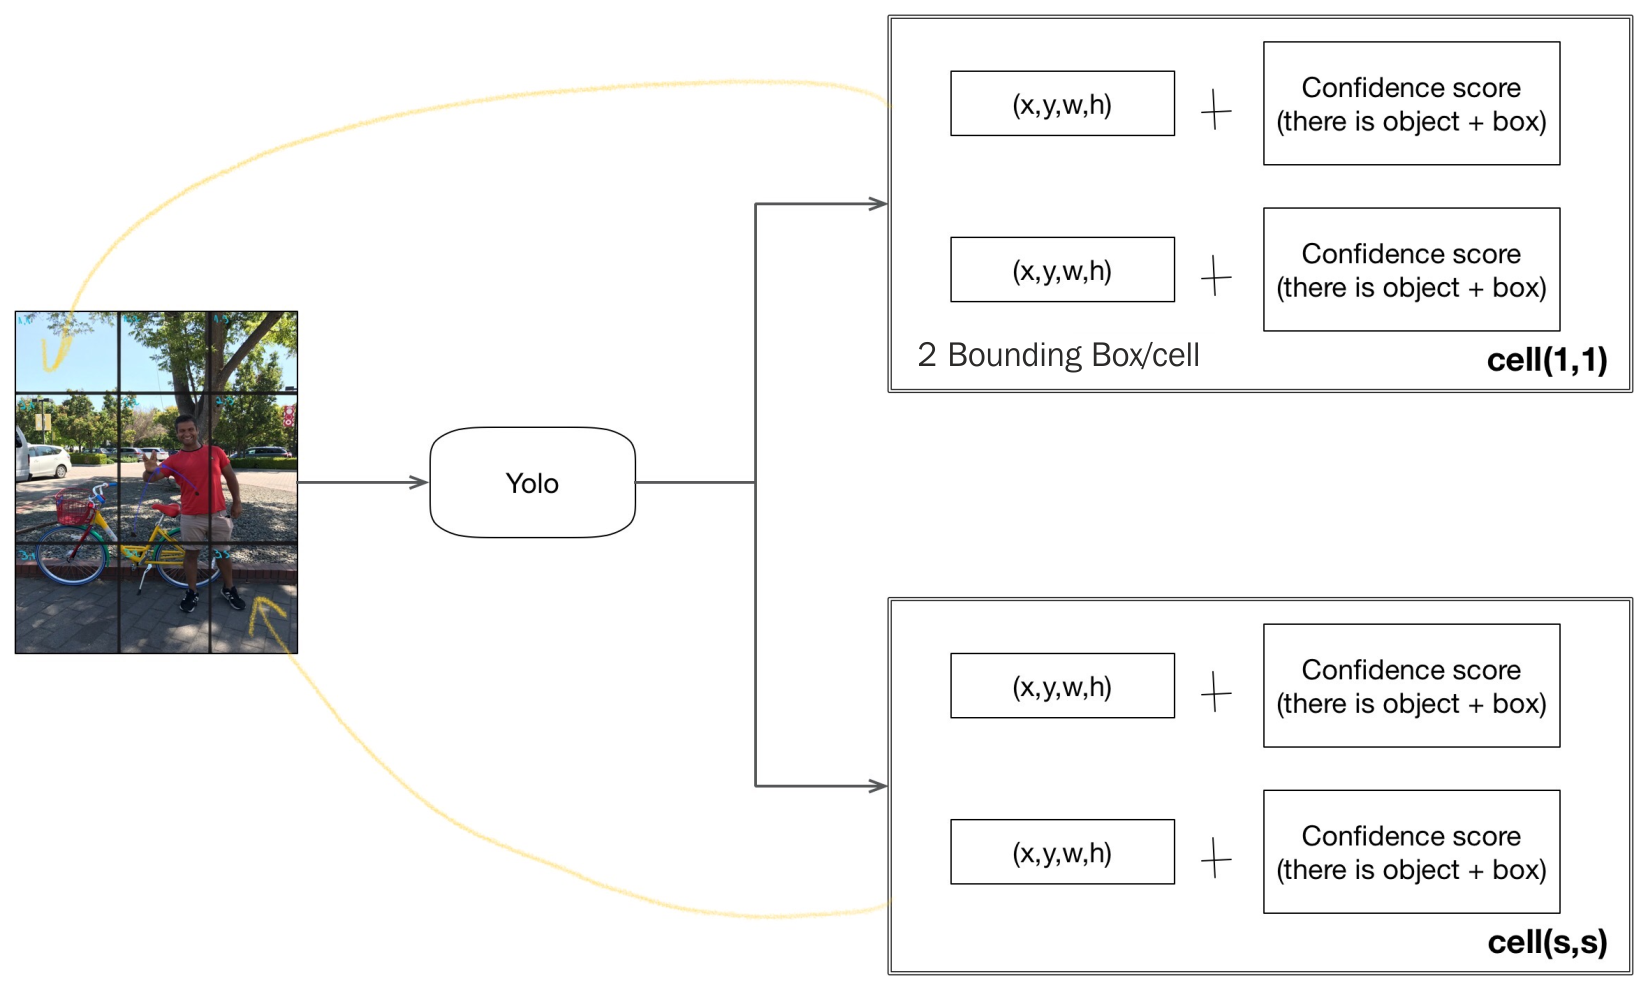

In [6]:
from IPython.display import Image
Image(filename='./images/yolo1.png',height=500,width=500)

The center coordinates and the height and width of the bounding box are normalized between [0 , 1].  The following figure shows an example of how to calculate these coordinates:

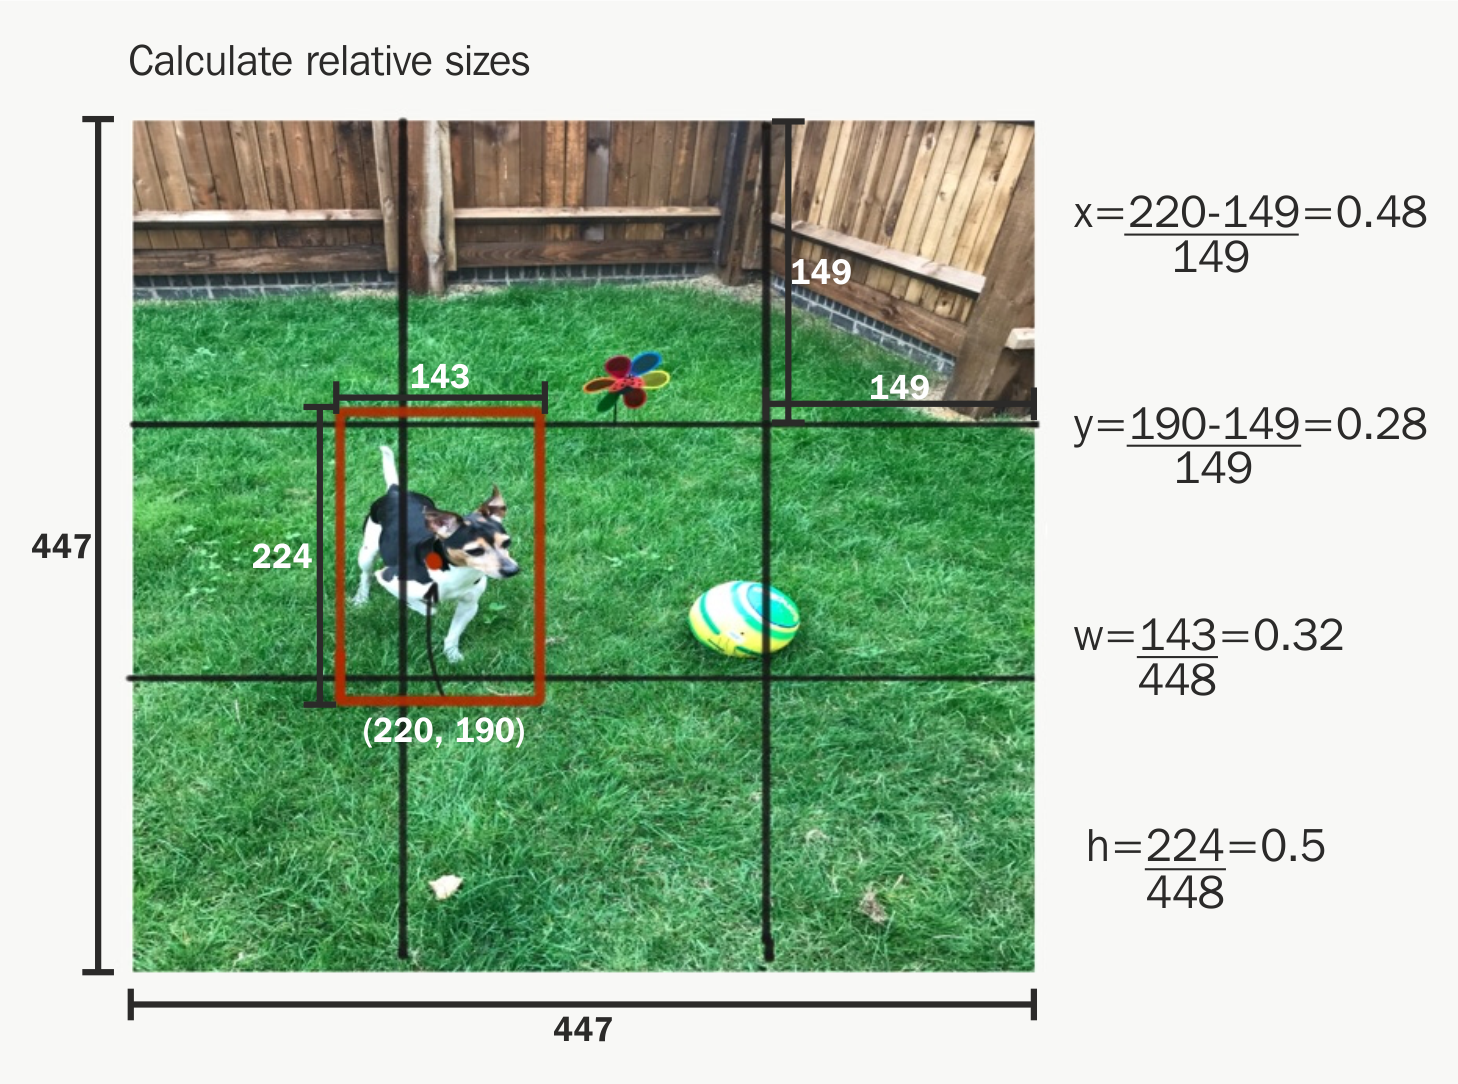

In [7]:
from IPython.display import Image
Image(filename='./images/yolo2.png',height=500,width=500)

The network predicts class probabilities, bounding boxes, and confidence for these boxes for each of these cells.

The actual YOLO network has 24 convolutional layers, followed by 2 fully connected layers. However, Fast YOLO network is 9 layers, as shown:

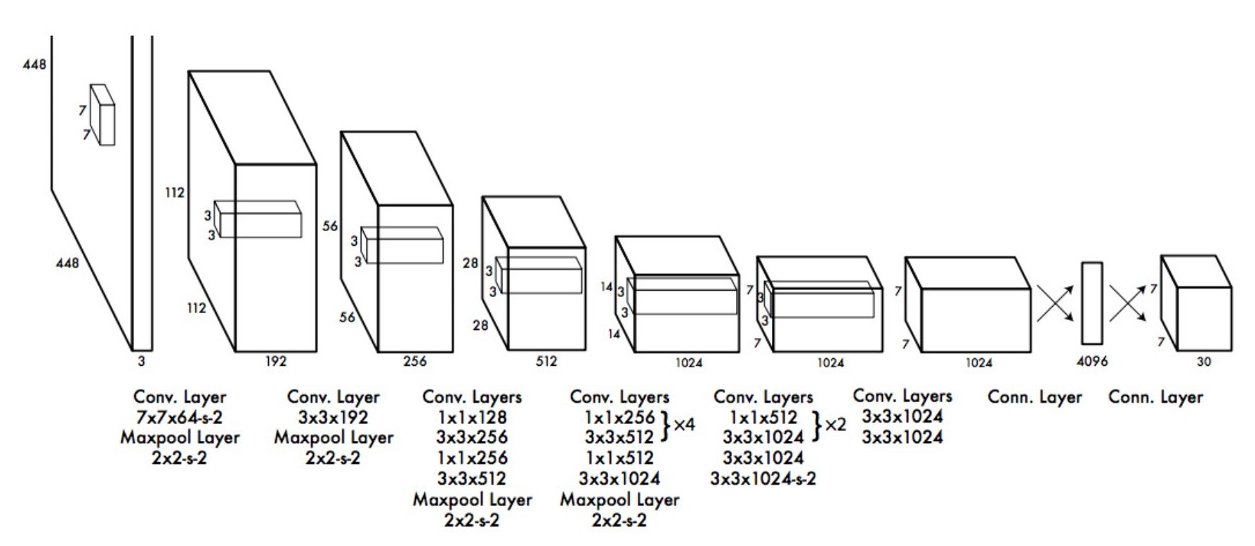

In [8]:
from IPython.display import Image
Image(filename='./images/yolo3.png',height=500,width=500)

Another important point is that each object will be assigned to one grid cell alone (based on this center and the cell distance) even if it appears to be on multiple cells.

Currently, we can imagine that the number of objects that can be detected on the image will be the grid size; later, we will see how to handle multiple objects per grid cell. (Anchor boxes)

### Creating training set for Yolo object detection

To create the training set for YOLO, a grid of the same size as output feature map prediction from the YOLO network is placed on each training input image. For each cell within the grid, we create a target vector Y of length B*5+C (that is, the same as output feature map grid cell size in the preceding section).

Let's take an example training image and see how we create target vector for cells in grid on the image:



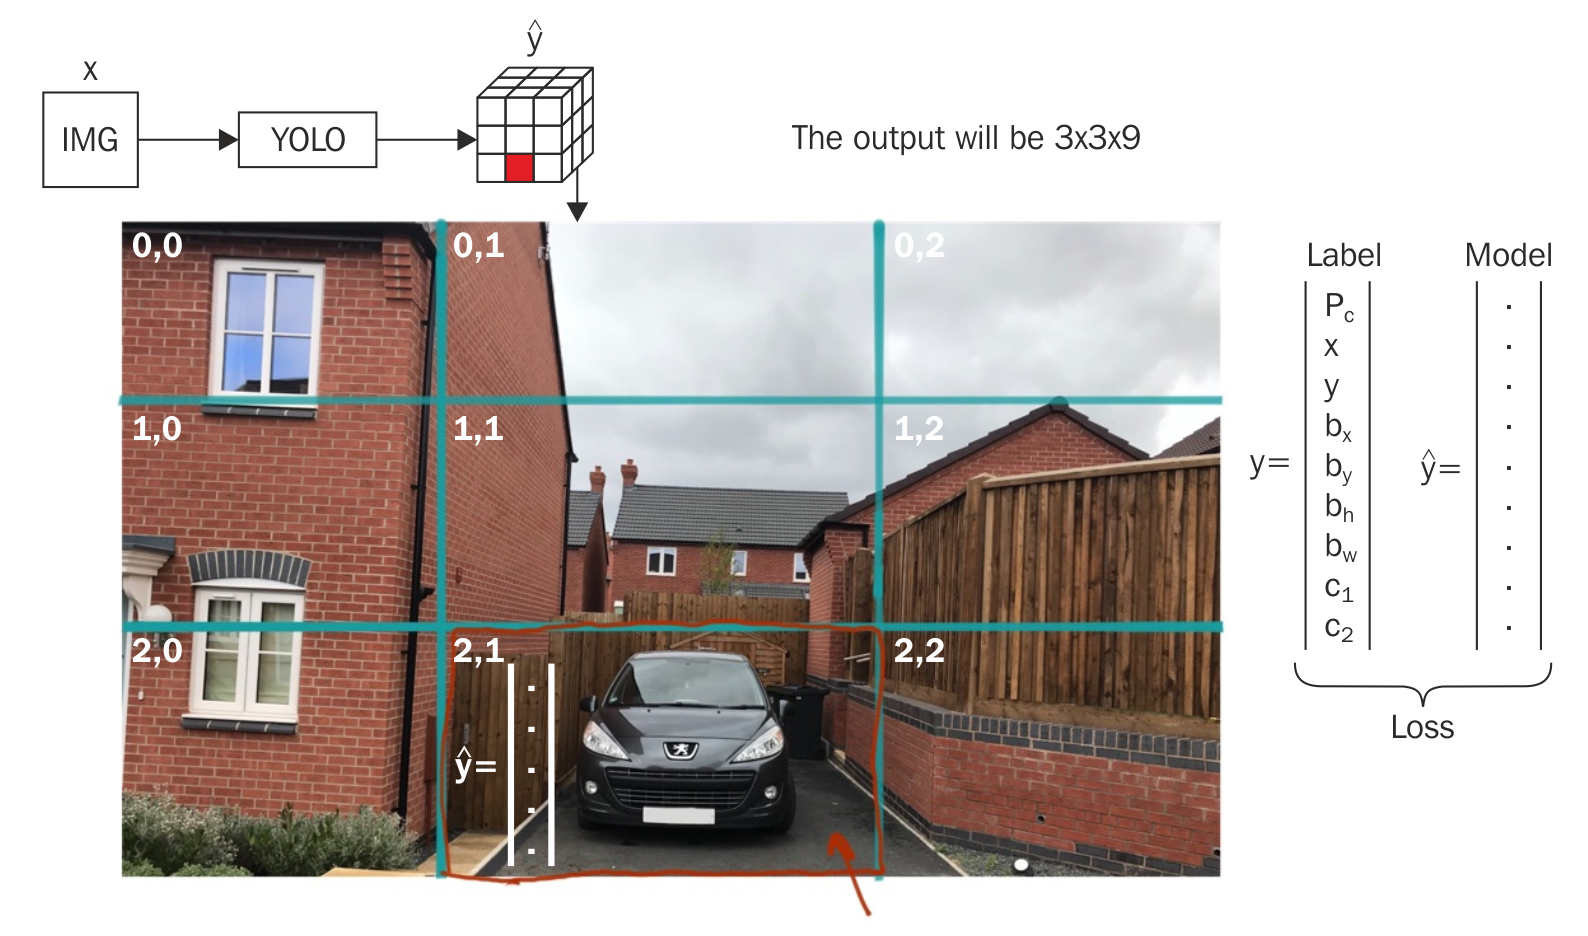

In [9]:
from IPython.display import Image
Image(filename='./images/yolo4.png',height=500,width=500)

In the preceding illustration, consider that we choose the cell based on the shortest distance of the object center (in the image, the back car's center is closest to the green cell).  If we look at the training image above we notice that object of class of interest  is only present in one cell that is cell number 8. Rest of the cells 1-7 and 9 don’t have any object of interest. The target vector for each cell will have 16 entries and look like following:

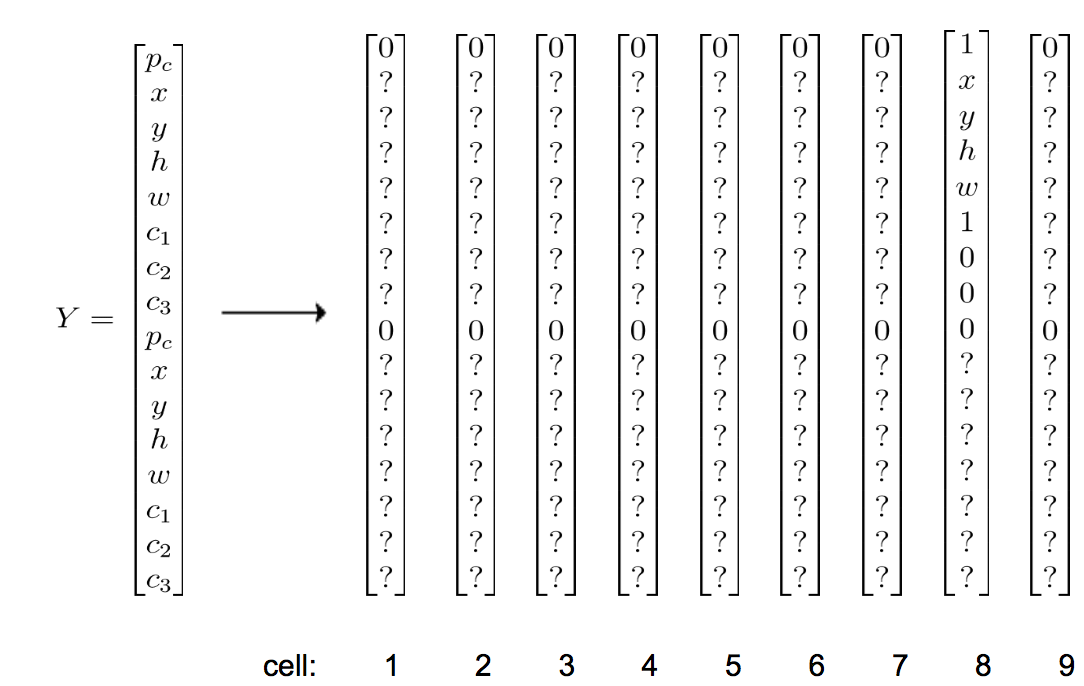

In [3]:
from IPython.display import Image
Image(filename='./images/yolo5.png',height=500,width=500)

First entry which is confidence score for the presence of class  which is 0 for both anchor boxes in cells which don’t have any object. Rest of the values will be don't cares. Cell number 8 has an object and the bounding box of object  has high IOU.

The final volume of the target vector output from ConvNet after training for the input training image of size NxM will be 3x3x16 (On this toy example)

The label information for each image in your dataset will just include the objects' center coordinates and their bounding boxes. It’s your responsibility while implementing the code to make it match the output vector of your network; these include tasks like the ones listed:

Transforming the image space into your grid space for each center point
Transform the bounding box dimensions on the image space to grid space dimensions
Find which cell is closest to your object on the image space

If we multiply each cell class's probability with the confidence for each bounding box, we will get some detections that can be filtered by another algorithm (Non-Maxima Suppression).

Let's define confidence as something that reflects the presence or absence of an object of any class on the cell. (Note that if there is no object on the cell, the confidence should be zero, and if there is an object, the confidence should be the IoU):



We also need to define a conditional class probability; given the presence of an object P(class|Pr), we want this because we don't want the loss function to penalize a wrong class prediction if there is no object on the cell. The network only predicts one set of class probabilities per cell, regardless of the number of boxes, B.

### Evaluating detection (Intersection Over Union)

Before we move further, we need to know how to measure whether our model detected an object correctly or not; for this, we calculate the Intersection Over Union (IoU) that will return a number, telling us how good our detection was based on some reference (Ground Truth). IoU is calculated by dividing the area where a detection and ground-truth box overlap with each over by the total area covered by the detection and ground-truth box:

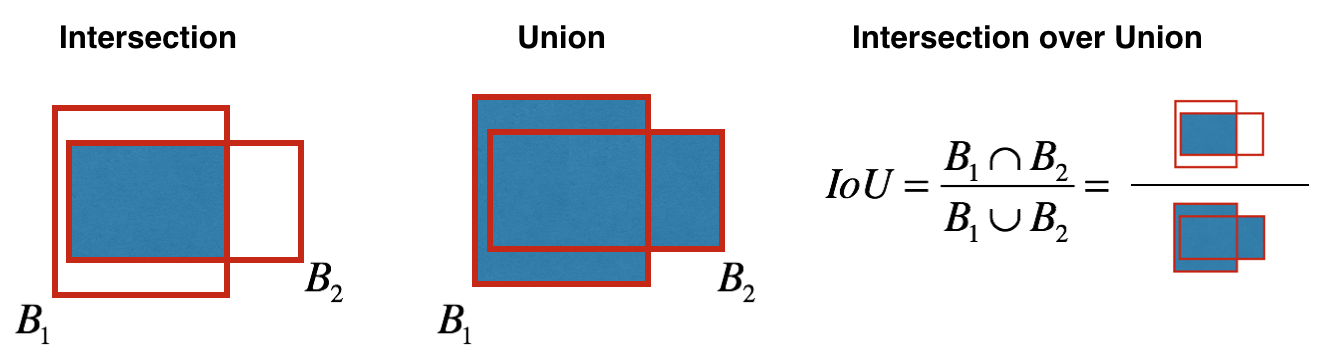

In [11]:
Image(filename='./images/yolo6.png',height=500,width=500)

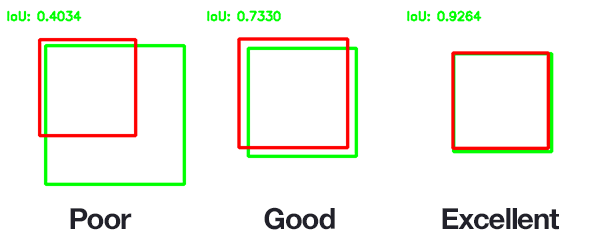

In [12]:
Image(filename='./images/yolo7.png',height=500,width=500)

By convention, if the IoU is bigger than 0.5, we consider that both boxes match and in this case, a detection is a true positive.

An IoU of zero means that the boxes don't intersect, and an IoU of one means a perfect match.

On our detector, if a cell has more than one  anchor boxes, IoU  helps to choose which one is responsible for object .We choose the anchor which has  highest IoU with the ground truth.

### Filtering output

More often than not, your model in practice will return multiple detection windows for the same object. To handle this, we use an algorithm called Non-Maximum Suppression. This algorithm filters these multiple boxes using the "IoU and presence of object" as heuristics. Here's how it works:

Discard all boxes with a low probability of containing an object (pc < 0.6)
Select the box with the biggest probability of having an object (pc on our label)
Discard all boxes with a high overlap with the selected box (IoU > 0.5)
Repeat steps 2 and 3 until all detections are either discarded or selected

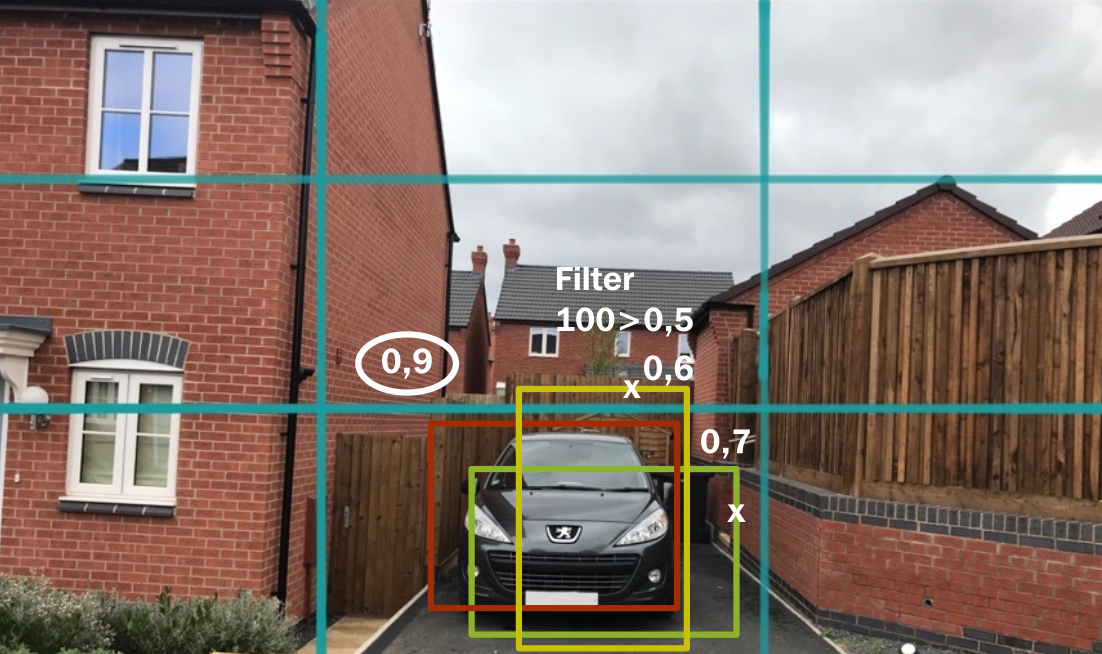

In [14]:
Image(filename='./images/yolo8.png',height=500,width=500)

Tensorflow already has a function that implements the non-maxima suppression algorithm, called tf.image.non_max_suppression.

### Anchor Box
Anchor boxes predefined template boxes of certain height and width ratio. These are used in YOLO  to help detect multiple objects from a single grid cell. We define the shape of boxes based on rough geometry of type of objects that can be detected.

Currently, as explained, our model will be able to detect only one object per grid cell, but in most cases, you may have multiple objects per cell. Remember that we consider the cell closest to the object to be the center:

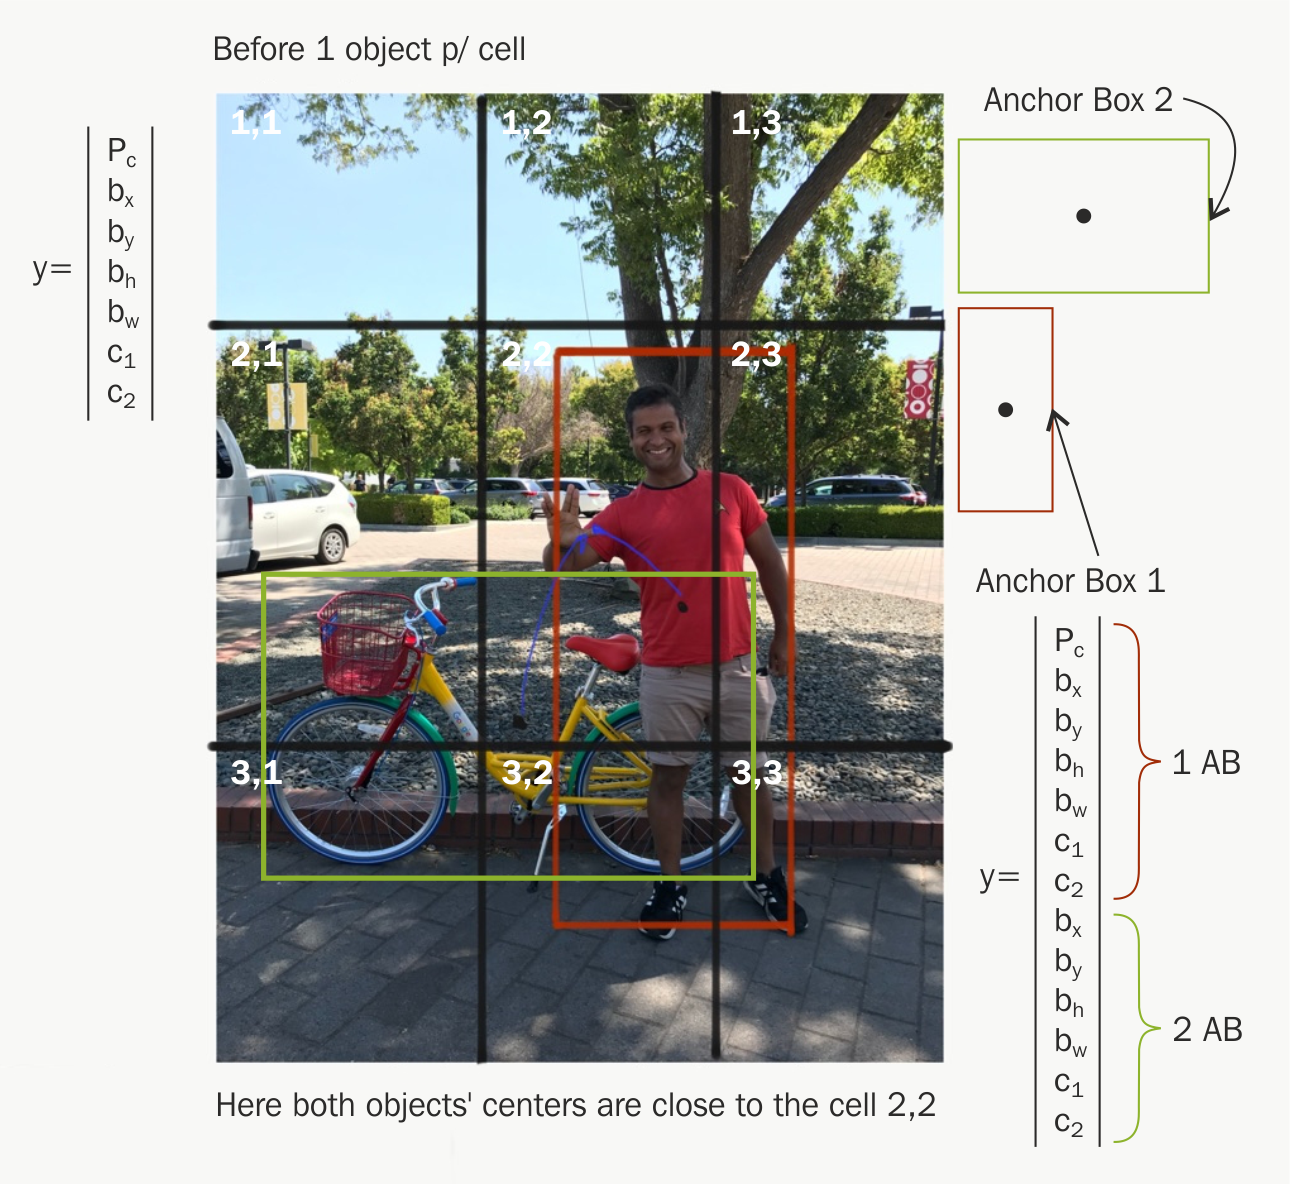

In [15]:
Image(filename='./images/yolo9.png',height=500,width=500)

To solve this, we need Anchor points; basically, we will add to our output depth volume a predefined bounding box; then, during training, we choose the objects with the center closest to a particular cell and choose the bounding box with the biggest IoU to the anchor box. In practice, the idea of anchor boxes make the network generalize the detection better, due to the fact that several subnetworks will be responsible for looking for other objects on the same cell.

#### Detector Loss function (YOLO loss)

As the localizer, the YOLO loss function is broken into three parts: the one responsible for finding the bounding-box coordinates, the bounding-box score prediction, and the class-score prediction. All of them are Mean-Squared error losses and are modulated by some scalar meta-parameter or IoU score between the prediction and ground truth:



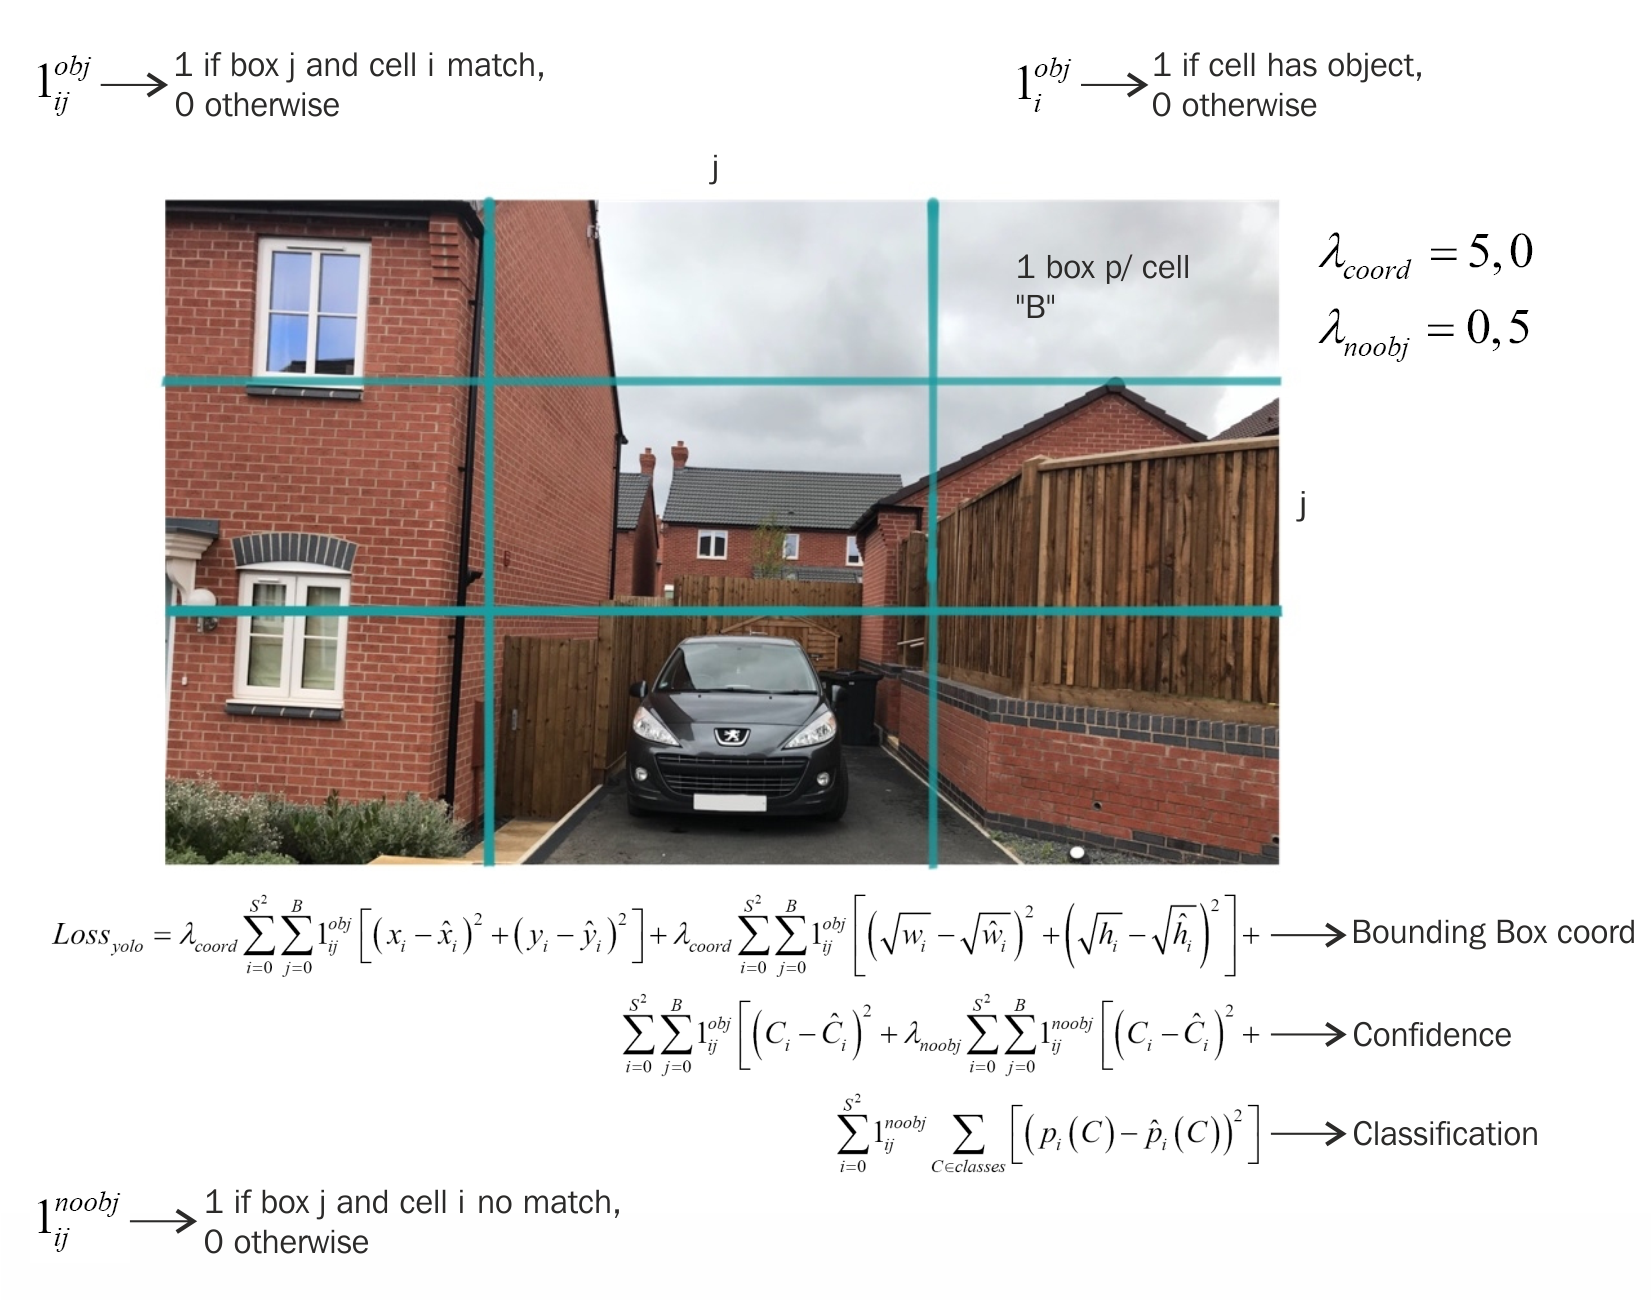

In [4]:
Image(filename='./images/yolo11.png',height=500,width=500)

The member 1ij obj member is used to modulate the loss based on the presence of an object on a particular cell i, j:<br>

If an object is present in grid cell i and the jth bounding box having the highest IoU: 1<br>
Otherwise: 0<br>
Also, 1ij noobj is just the opposite.